# StepMatrix

## Step matrix definition

Step matrix is a powerful tool in the retentioneering arsenal. It allows getting a quick high-level understanding of user behavior. Step matrix has powerful customization options to tailor the output depending on the goal of the analysis.

To better understand how step matrix works let’s first consider an intuitive example. Suppose we are analyze web-store logs and have a dataset with event logs from four user sessions with the following events in the following order:

step_matrix_demo.svg

We can visualize this dataset as a step-wise heatmap  indicating the distribution of the events appeared at a specific step:

In [1]:
from retentioneering.eventstream import Eventstream
import pandas as pd

/Users/j.ostanina/Rete/retentioneering-tools-new-arch/retentioneering/params_model/params_model.py:68: UserWarning: Callable func was excluded from schema since JSON schema has no equivalent type.
  params_schema: dict[str, Any] = cls.schema()


/Users/j.ostanina/Rete/retentioneering-tools-new-arch/retentioneering/eventstream/eventstream.py:664: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


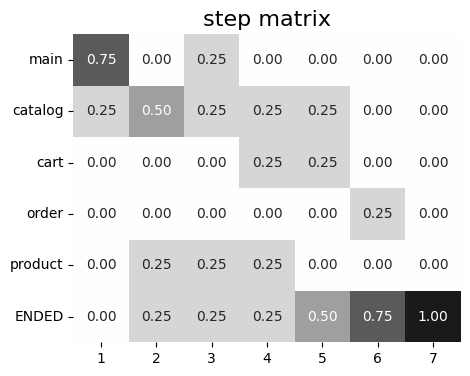

In [2]:
simple_example = pd.DataFrame({
    'user_id': ['user1', 'user2', 'user3', 'user4', 
                'user1', 'user3', 'user4', 
                'user1', 'user3', 'user4', 
                'user1', 'user3', 'user4', 
                'user1', 'user3',
                'user3'
               ], 
    'event': ['main', 'main', 'main', 'catalog',
              'catalog', 'catalog', 'product',
              'product', 'catalog', 'main',
              'cart', 'product', 'catalog',
              'catalog', 'cart',
              'order'
             ],
    'timestamp': [0, 0, 0, 0,
                  1, 1, 1,
                  2, 2, 2,
                  3, 3, 3,
                  5, 5,
                  6
                 ]
})

Eventstream(simple_example).step_matrix(max_steps=7);

This is the simplest step matrix. The matrix rows correspond to the unique events, and the columns correspond to the steps in the user trajectories. So that ``(i, j)`` matrix element show the percantage of the users who had event ``i`` appeared at step ``j``.

Below we will explore how to plot and customize the step matrix.


Loading data
------------

In [3]:
from retentioneering import datasets

stream = datasets.load_simple_shop()

## Basic example

StepMatrix tool is mainly available as `Eventstream.step_matrix()` method. Here's how it visualizes ``simple_shop`` eventstream:




/Users/j.ostanina/Rete/retentioneering-tools-new-arch/retentioneering/eventstream/eventstream.py:664: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


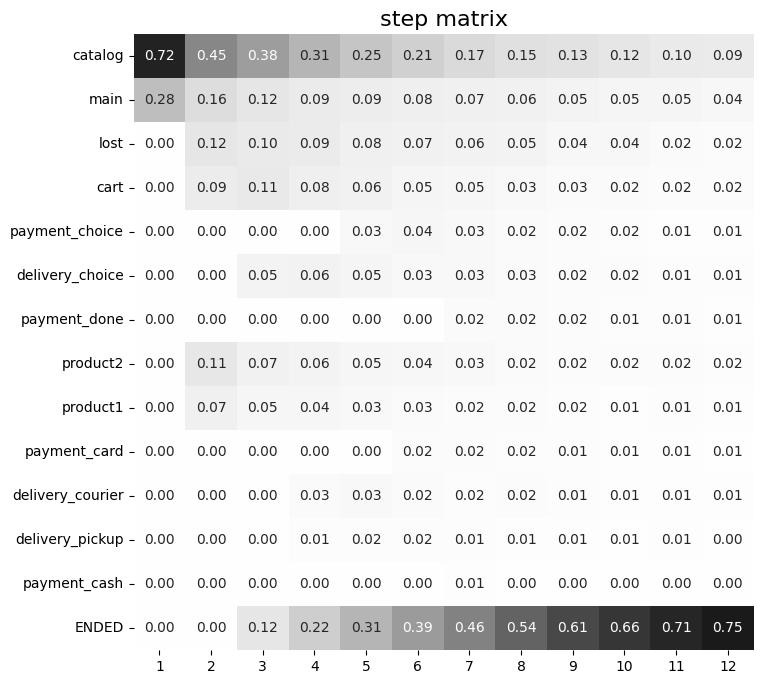

In [4]:
stream.step_matrix(max_steps=12)

As you can see, the sum of the values ​​in the cells of the matrix at each step is 1. Looking at the first column we can immediately say that the users in the analyzed eventstream start their sessions from events ``catalog`` (72%) and ``main`` (28%). 
We are potentially interested in the payment_done event, and the step matrix shows that it appears in the trajectories no earlier than the seventh step (row payment_done have 0.02 at step 7).

Terminating event
-----------------

As you may know, ``ENDED`` is a special synthetic event which explicitly indicates a trajectory's end. If a user's path is shorter than ``max_steps`` parameter, ``path_end`` is padded the path so that it becomes exactly of length ``max_steps``. Having this behavior implemented, we can guarantee that the sum of the user fractions over each column (i.e. each step) is exactly 1.
``ENDED`` is always placed to the bottom. This line calculates the cumulative share of users who left the clickstream at each step.

Collapsing rare events
----------------------
Often we need to collapse rare events in the step matrix since these events make it excessively noisy. This behaviour is controlled by ``thresh`` argument. An event is considered as rare if its maximum frequency over all the steps represented in the diagram is less than ``thresh``. All these rare events are not removed from the matrix, but collapsed to ``thresholded_N`` artificial event instead where ``N`` stands for the number of the collapsed events. ``thresholded_N`` event appears in the step matrix only and is not added to the parent eventstream. 

Let's look how the events are adsorbed if we set ``thresh=0.05`` and compare the result with the previous step matrix (with default ``thresh=0`` parameter).

/Users/j.ostanina/Rete/retentioneering-tools-new-arch/retentioneering/eventstream/eventstream.py:664: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


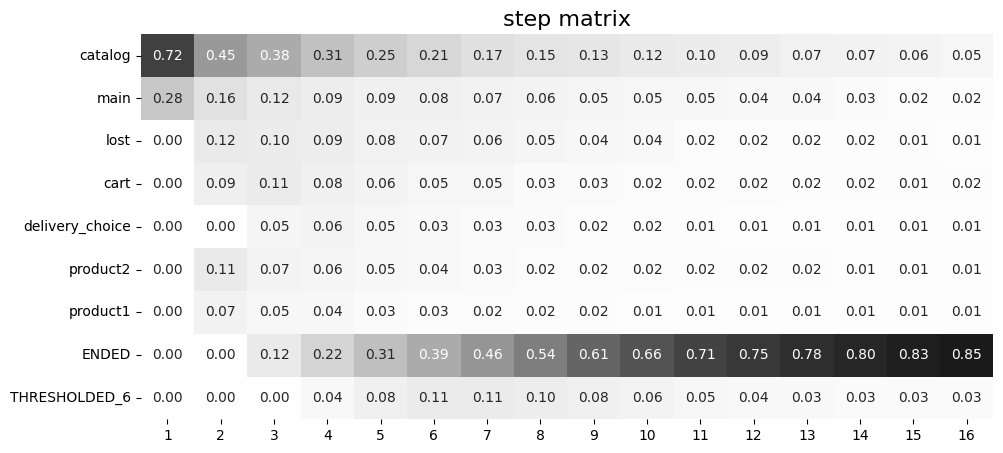

In [5]:
stream.step_matrix(max_steps=16, thresh=0.05);

All the rare eventsevents cutted away by thresholding are grouped together in ``THRESHOLDED_N`` row, where N - is the total number of dropped events. 
We see that thresholded_6 contains delivery_courier, delivery_pickup, payment_cash, payment_card, payment_done, payment_choice. Look at the ``payment_choice`` event in the previous step matrix: at step 5 this event contains 3% of the users, 4% at step 6, and 3% at step 7. Since the maximum value (3%) is less than thresh=0.05, the event is collapsed.

Please also note that the number _6 in the thresholded_6 event name carries no information on a specific step. For example, from the matrix with thresh=0 we see that at step 4 only one event among these 6 is represented (delivery_courier), so it is the only event which is collapsed at this step. On the other hand, at step 5 delivery_pickup and payment_choice appear, so they are collapsed to thresholded_6 event. Finally, at step 7 all these 6 events are collapsed.

It you want to prevent some events from the collapsing, use target parameter then. 

### Targets analysis

In product analysis we often deal with the events of particular importance. This includes events such as adding an item to the cart, order confirmation, payment, etc.. Such events have much lower occurrence rate comparing with other events (like visiting main page or catalog) and because of this are lost as collapsed to ``THRESHOLDED_N`` or shown with non-informative coloring. In this case we can isolate those events (targets) to individual rows, each of which will have their individual color scale. This can be done with parameter ``targets``:

/Users/j.ostanina/Rete/retentioneering-tools-new-arch/retentioneering/eventstream/eventstream.py:664: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


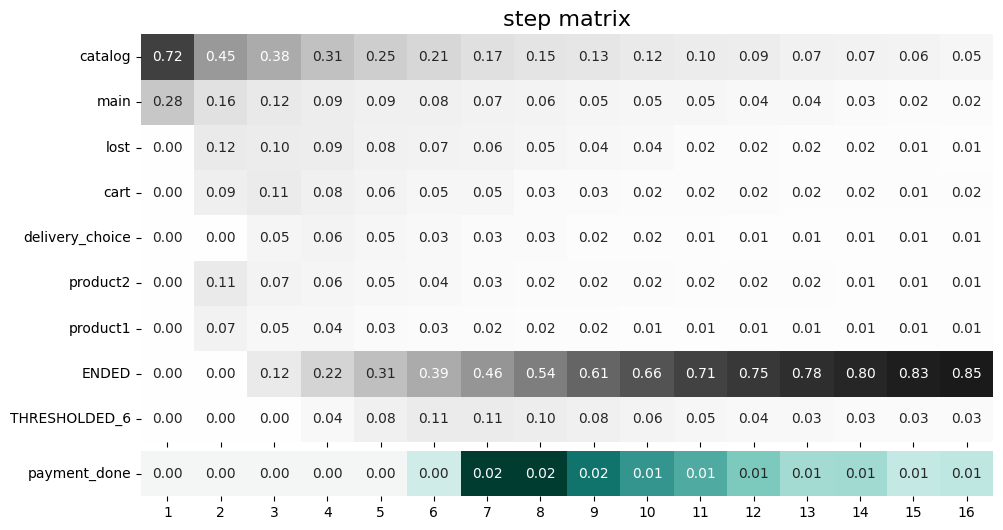

In [6]:
stream.step_matrix(max_steps=16,
    thresh=0.05,
    targets=['payment_done'])

Specified target events are always shown in the bottom of step matrix regardless of selected threshold. As we chose the ``payment_done`` event as a target, the row with ``payment_done`` moved to the end of the matrix and now has its own palette.

Multiple targets can be included as a list:

/Users/j.ostanina/Rete/retentioneering-tools-new-arch/retentioneering/eventstream/eventstream.py:664: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


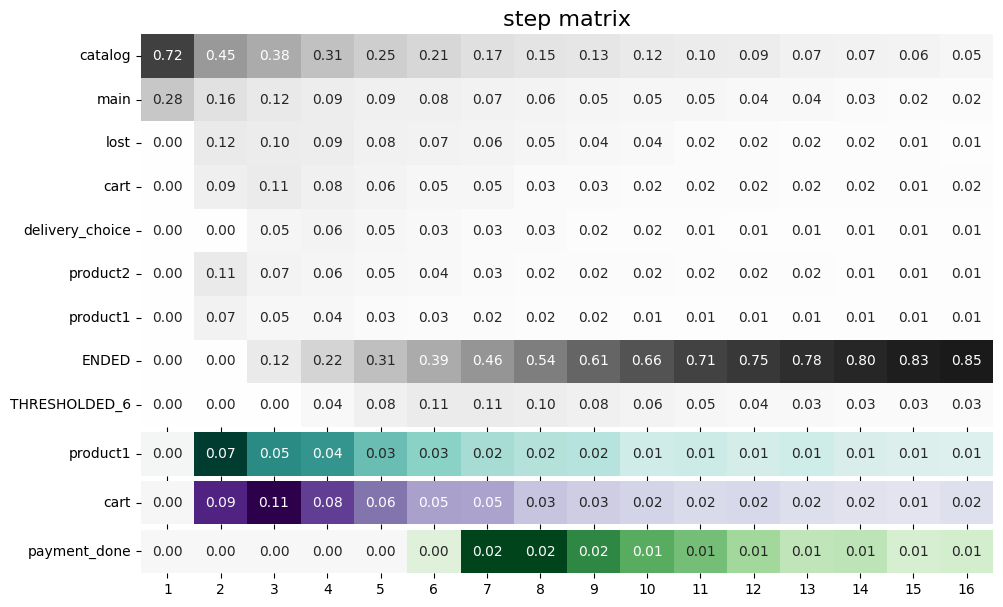

In [7]:
stream.step_matrix(max_steps=16,
    thresh=0.05,
    targets=['product1','cart','payment_done'])

Now we have selected three target events: ``product1``, ``cart``, ``payment_done``, so we can see them in the end of matrix. Each of them has its own palette and color scaling.

If we want to compare some targets and plot them using the same color scaling, we can combine them in a sub-list inside the targets list:

/Users/j.ostanina/Rete/retentioneering-tools-new-arch/retentioneering/eventstream/eventstream.py:664: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


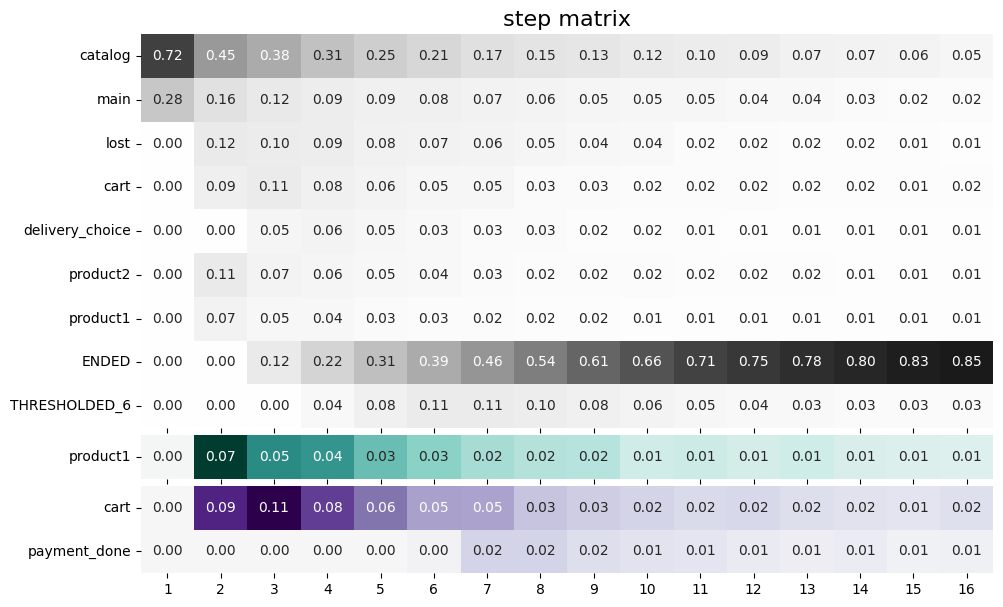

In [8]:
stream.step_matrix(max_steps=16,
    thresh=0.05,
    targets=['product1',['cart','payment_done']])

Now we can visually compare by color how many users reach ``cart`` vs ``payment_done`` at particular step in their trajectory.

Targets can be presented as accumulated values. It means we can display the cumulative sum of the share of the users who had this event at each step. 
Rows with accumulated values ​​start with "ACC_". There are two options for displaying these rows: 

1.   ``only`` accumulated rows;
2.   ``both`` not accumulated and accumulated values, two rows with different color scaling for each event.


/Users/j.ostanina/Rete/retentioneering-tools-new-arch/retentioneering/eventstream/eventstream.py:664: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


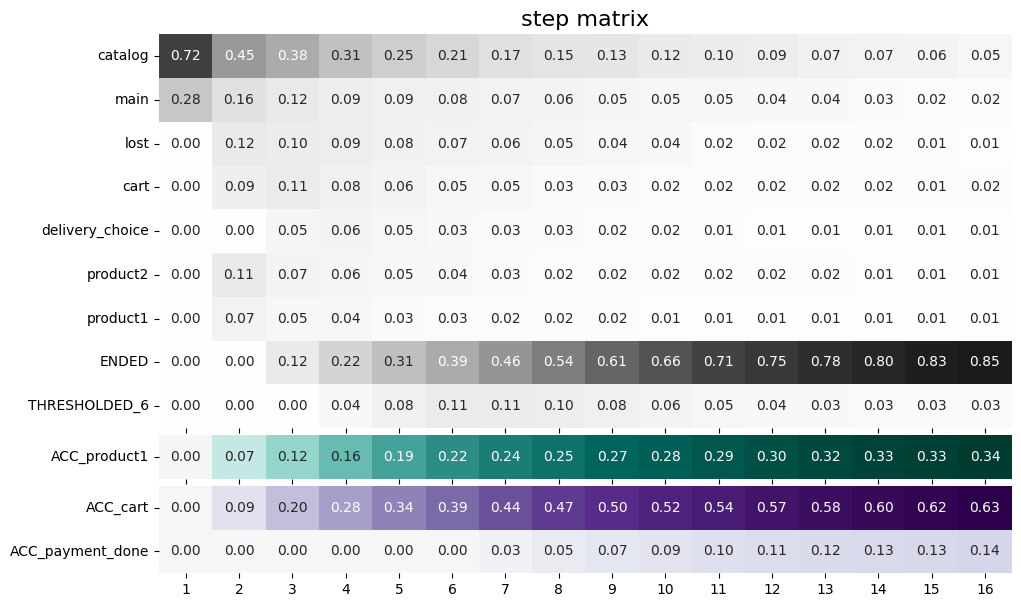

In [9]:
stream.step_matrix(max_steps=16,
    thresh=0.05,
    targets=['product1',['cart','payment_done']],
    accumulated='only');

/Users/j.ostanina/Rete/retentioneering-tools-new-arch/retentioneering/eventstream/eventstream.py:664: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


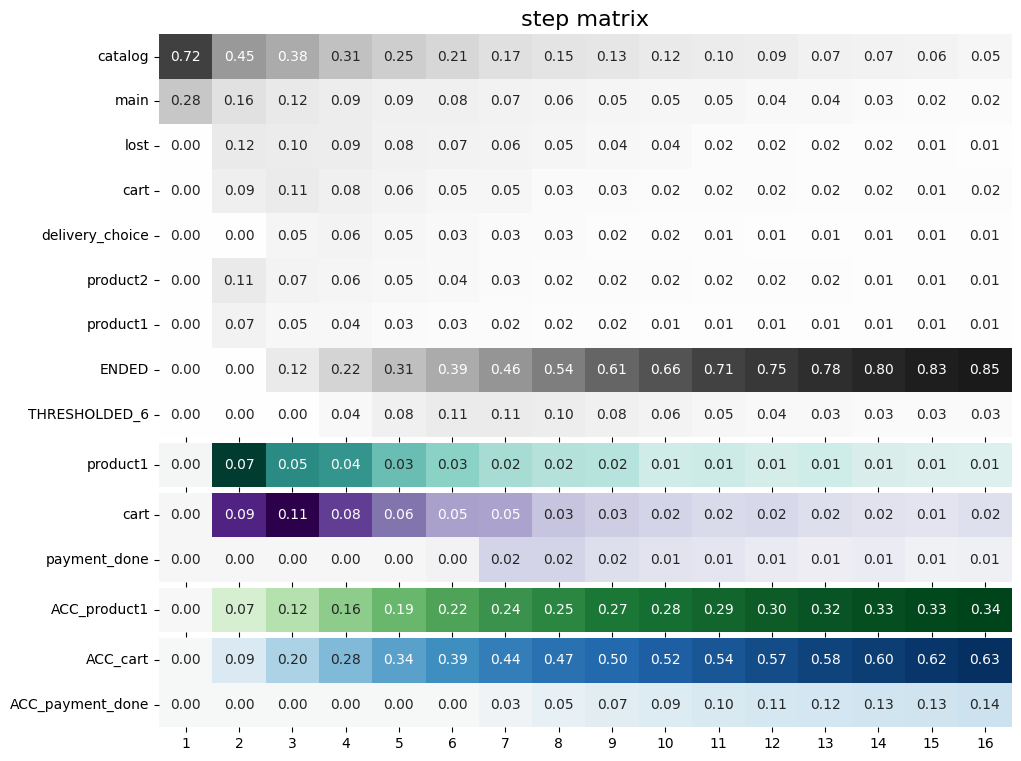

In [10]:
stream.step_matrix(max_steps=16,
    thresh=0.05,
    targets=['product1', ['cart', 'payment_done']],
    accumulated='both')

### Centered step matrix

Sometimes we are interested in flow of users through a specific event: how do users reach a specific event and what do they do after? This information can be visualized with step_marix using parameter ``centered``:

/Users/j.ostanina/Rete/retentioneering-tools-new-arch/retentioneering/tooling/step_matrix/step_matrix.py:323: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data = data.groupby(self.weight_col).apply(self._pad_to_center)  # type: ignore
/Users/j.ostanina/Rete/retentioneering-tools-new-arch/retentioneering/eventstream/eventstream.py:664: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


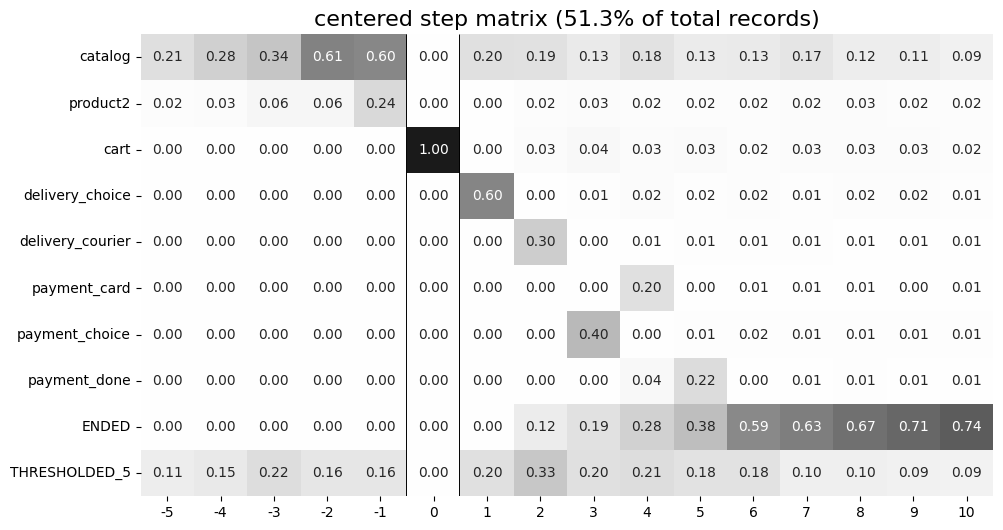

In [11]:
stream.step_matrix(max_steps=16,
    thresh=0.2,
    centered={
        'event': 'cart',
        'left_gap': 5,
        'occurrence': 1})

Parameter ``centered`` is a dictionary which requires three keys:

* ``event`` - the name of the event we are interested in. Reaching this event will be associated with step 0. Negative step numbers will correspond to events occurred before the selected event and positive step numbers will correspond to steps occurred after the selected event;

* ``left_gap`` - the integer number which indicates how many steps before the centered event we want to show in the step matrix;

* ``occurrence`` - which occurrence number of the target event we are interested in. For example, in the illustration above, all the trajectories will be aligned to have **the first** ‘cart’ occurrence as step 0.

Importantly, when a centered step matrix is used, only users who have selected events in their trajectories present (or it’s n`th occurrence) will be shown. Therefore, the column with step index 0 will always have 1 at the selected event and zero at all other events. The fraction of the users kept for the centered step matrix is shown in the title. In the example above, 51.3% of users have reached the event ‘cart’ at least **once**.




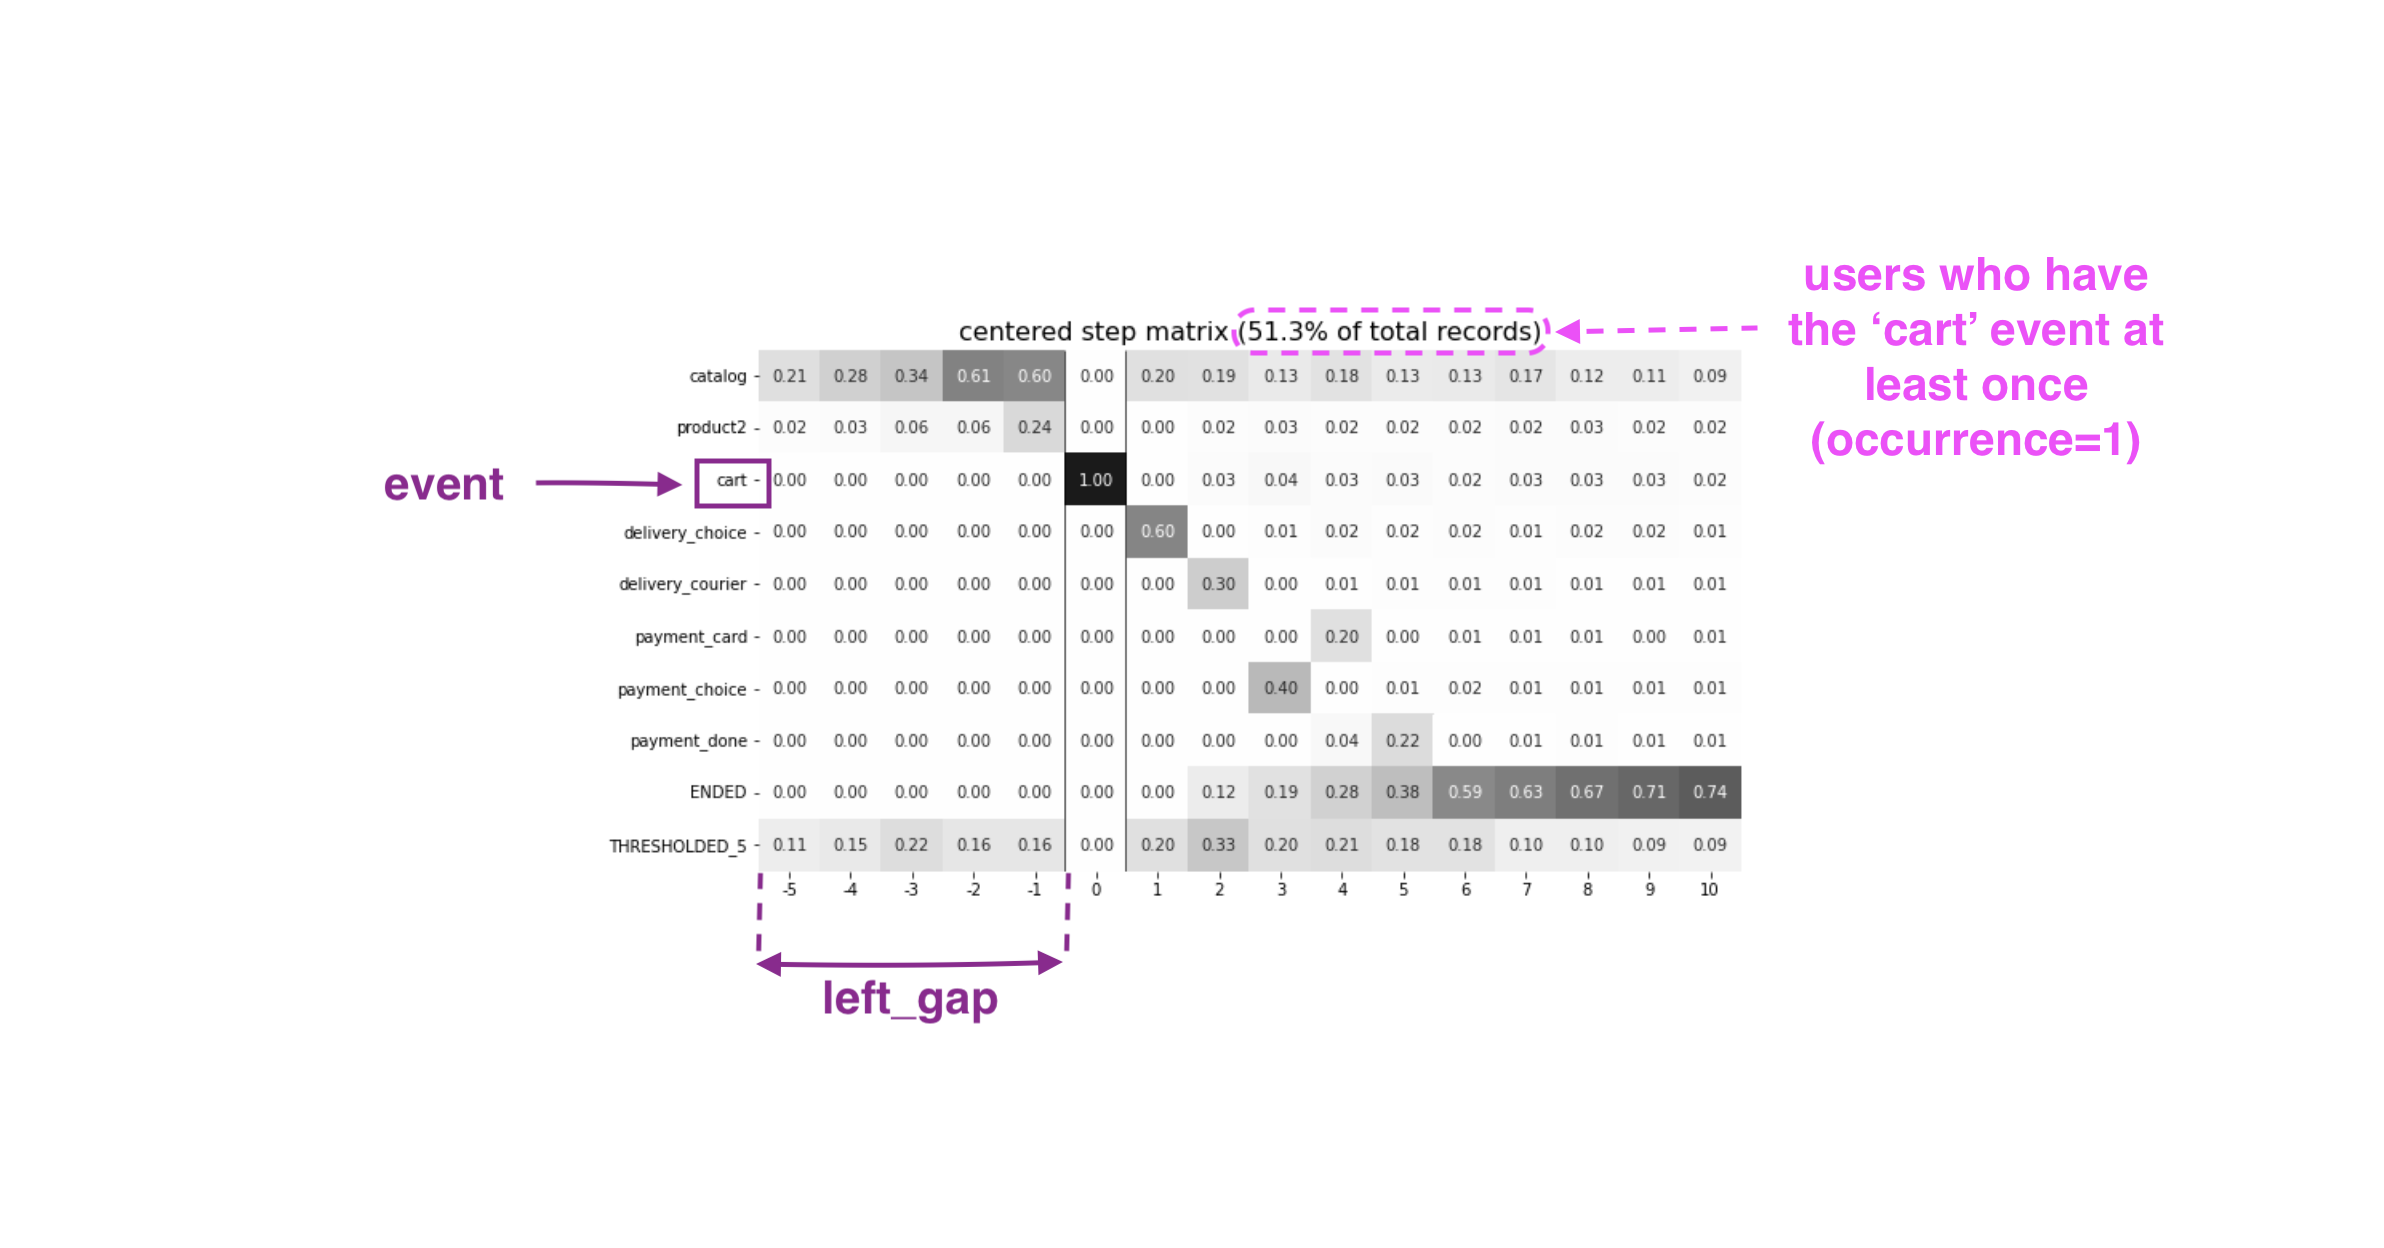

To better understand the meaning of the ``occurrence`` parameter, let's build another step matrix, this time with ``occurrence=2``:

/Users/j.ostanina/Rete/retentioneering-tools-new-arch/retentioneering/tooling/step_matrix/step_matrix.py:323: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data = data.groupby(self.weight_col).apply(self._pad_to_center)  # type: ignore
/Users/j.ostanina/Rete/retentioneering-tools-new-arch/retentioneering/eventstream/eventstream.py:664: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


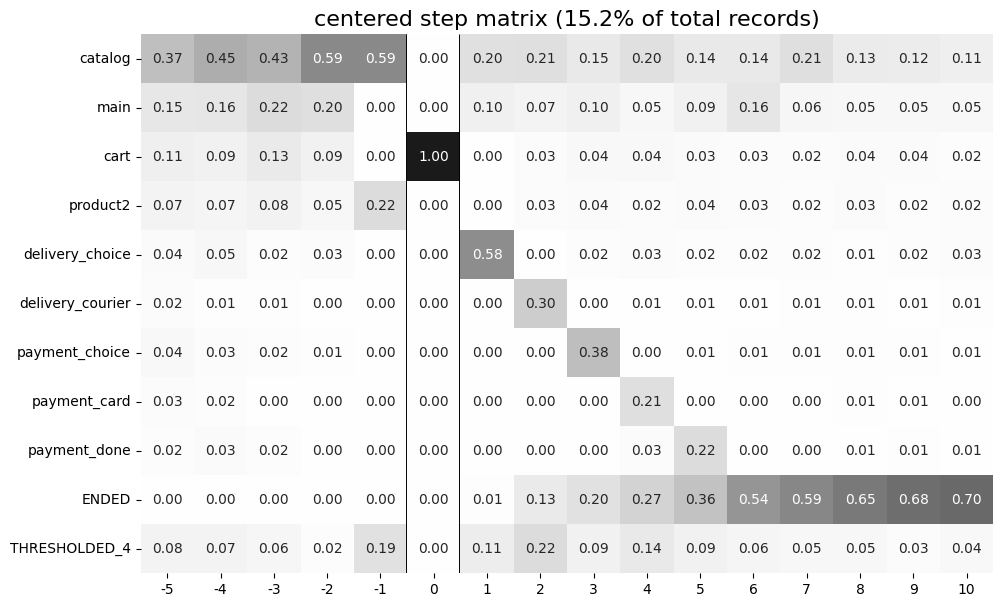

In [12]:
stream.step_matrix(max_steps=16,
    thresh=0.2,
    centered={
        'event': 'cart',
        'left_gap': 5,
        'occurrence': 2})

Here we can see that the proportion of users whose steps are displayed in our matrix has noticeably decreased.  Now they are 15.2%, because we are evaluating the **second** occurrence of the ``cart`` event, which means we are considering users who had this event at least **twice**.

A combination of ``targets`` and ``centered`` parameters is also possible:

/Users/j.ostanina/Rete/retentioneering-tools-new-arch/retentioneering/tooling/step_matrix/step_matrix.py:323: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data = data.groupby(self.weight_col).apply(self._pad_to_center)  # type: ignore
/Users/j.ostanina/Rete/retentioneering-tools-new-arch/retentioneering/eventstream/eventstream.py:664: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


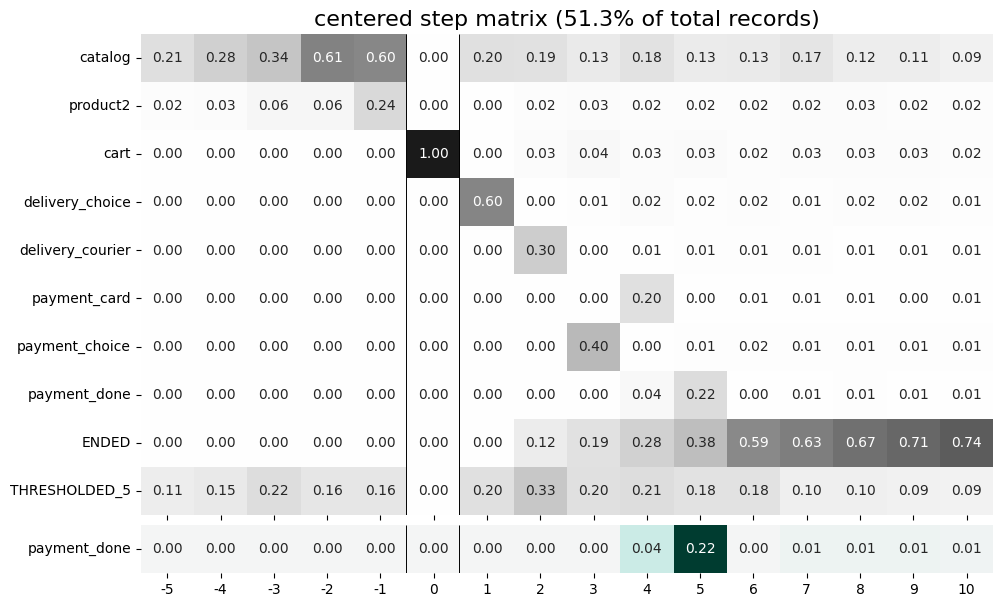

In [13]:
stream.step_matrix(max_steps=16,
    thresh = 0.2, 
    centered={'event':'cart',
        'left_gap':5,
        'occurrence':1},
    targets=['payment_done'])


### Events sorting

By default, rows in the step matrix are sorted in the next order: 

1. real events in the order of the first occurrence in eventstream
2. ``ENDED`` event
3. ``THRESHOLDED`` event
4. targets



Sometimes it is needed to obtain a step matrix with the events ranked in the specific order (for example, to compare two step matrices). This can be done with parameter ``sorting`` which accepts a list of event names in the required order to show up in the step matrix. Let’s consider an example:

/Users/j.ostanina/Rete/retentioneering-tools-new-arch/retentioneering/eventstream/eventstream.py:664: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


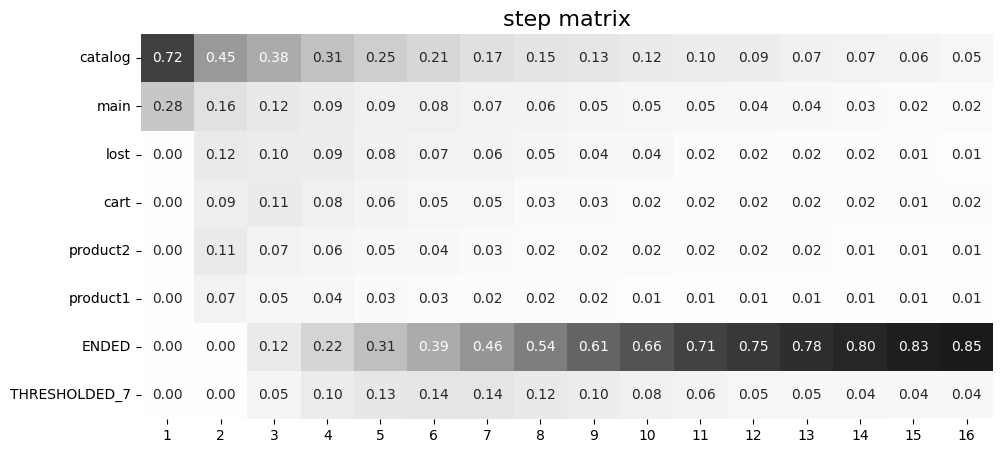

In [14]:
stream.step_matrix(max_steps=16,
    thresh=0.07)

Let’s say we would like to change the order of the events in the resulted step_matrix. First, we can obtain a list of event names from the step_matrix output using  ``.values[0]``


To read about the ``.values`` ​​attribute, follow the link:
https://colab.research.google.com/drive/1ZFesXKYsXLCcjFEGSS9AVNFdqjkbOya3#scrollTo=i3vvPGaGcR7p


/Users/j.ostanina/Rete/retentioneering-tools-new-arch/retentioneering/eventstream/eventstream.py:664: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


Index(['catalog', 'main', 'lost', 'cart', 'product2', 'product1', 'ENDED',
       'THRESHOLDED_7'],
      dtype='object')

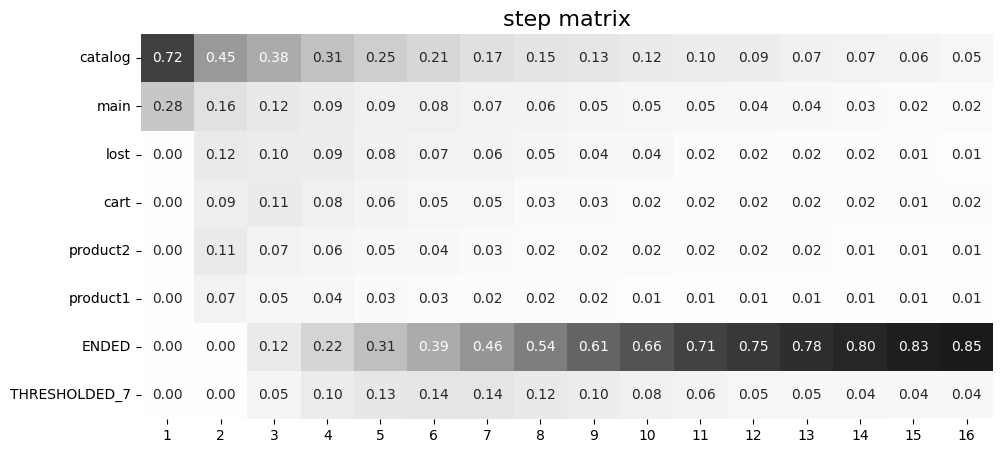

In [15]:
stream\
    .step_matrix(max_steps=16, thresh=0.07)\
    .values[0]\
    .index

Now we can conveniently copy the list of events, reorganize it in the required order and pass it to the step_matrix function as a sorting parameter:

/Users/j.ostanina/Rete/retentioneering-tools-new-arch/retentioneering/eventstream/eventstream.py:664: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


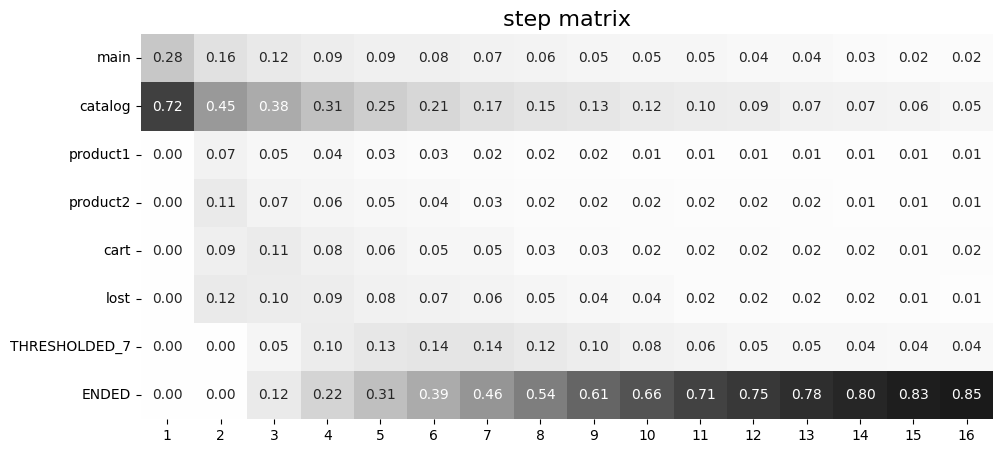

In [16]:
custom_order = ['main',
    'catalog',            
    'product1',
    'product2',
    'cart',
    'lost',
    'THRESHOLDED_7',
    'ENDED']
stream\
    .step_matrix(max_steps=16,
        thresh=0.07,
        sorting=custom_order)

Note, that the custom ordering only affects non-target events. Target events will always be in the same order as they are specified in the parameter ``targets``.

### Differential step_matrix

Sometimes we need to compare the behavior of several groups of users. For example, when we would like to compare the behavior of the users who had conversion to a target vs. those who had not, compare the behavior of test and control groups in an A/B test, or compare behavior between specific segments of the users. For example, now we want to compare the behavior of any abstract groups g1 and g2. In g1 we will add users who have the ``payment_done`` event in their trajectory, in g2 - all the rest. We will choose ``cart`` as the central event, because it is usually closely followed by a purchase or user disappearance.

In this case, it is informative to plot a step_matrix as the difference between step_matrix for group_A and step_matrix for group_B. This can be done using parameter ``groups``, which requires a tuple of two elements ``(g1, g2)``: where ``g_1`` and ``g_2`` are collections of the ``user_id``s (list, tuple, or set). Two separate step matrices M1 and M2 will be calculated for users from ``g_1`` and ``g_2``, respectively. The resulting matrix will be the matrix M = M1-M2. Note, that the values in each column in the differential step matrix will always sum up to 0 (since the columns in both M1 and M2 always sum up to 1).


/Users/j.ostanina/Rete/retentioneering-tools-new-arch/retentioneering/tooling/step_matrix/step_matrix.py:323: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data = data.groupby(self.weight_col).apply(self._pad_to_center)  # type: ignore
/Users/j.ostanina/Rete/retentioneering-tools-new-arch/retentioneering/tooling/step_matrix/step_matrix.py:323: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To 

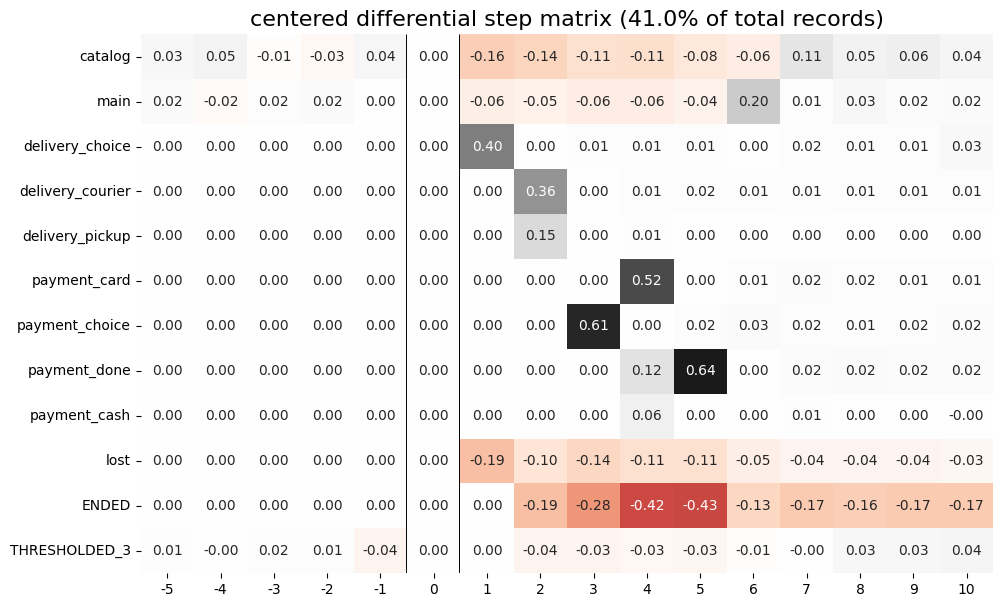

In [17]:
raw_data = stream.to_dataframe()

g1 = set(raw_data[raw_data['event'] == 'payment_done']['user_id'])
g2 = set(raw_data['user_id']) - g1

stream.step_matrix(max_steps=16,
    thresh = 0.05,
    centered={'event':'cart',
        'left_gap':5,
        'occurrence':1},
        groups=(g1, g2))

To correctly interpret the differential matrix, it is enough to keep in mind the idea that we have before us the result of subtracting one matrix from another. It means that if we see a value in a matrix cell that is equal to or close to zero, we understand that the share of this event at this step in the two groups is approximately equal. If we see a large negative number, then users from the second group performed this action more often at this step. If we see a large positive number, this means that this event happened more often for users from the first group.

For example, before the central event ``cart``, the values ​​in the cells of the matrix are close to zero, which means that the behavior of users in the two groups is approximately the same. However, after it, negative values ​​appear in the ``lost`` and ``ENDED`` row, which tells us that among users who did not make a purchase, many users were lost after adding the product to the cart. On the contrary, users who have made a purchase are dominated by ``payment_done``, ``payment_choice`` and ``payment_cart`` events.

#### Clusters

Consider another example of differential step matrix use, where we will compare behavior of two user clusters. First, let’s obtain behavioural segments and visualize the results of the segmentation using conversion to ``payment_done`` and event ``cart``.

To learn more about user behavior clustering read here:
https://colab.research.google.com/drive/1czRNCWcena5KlyPIJR7RRuXNQltl9mKQ?usp=sharing

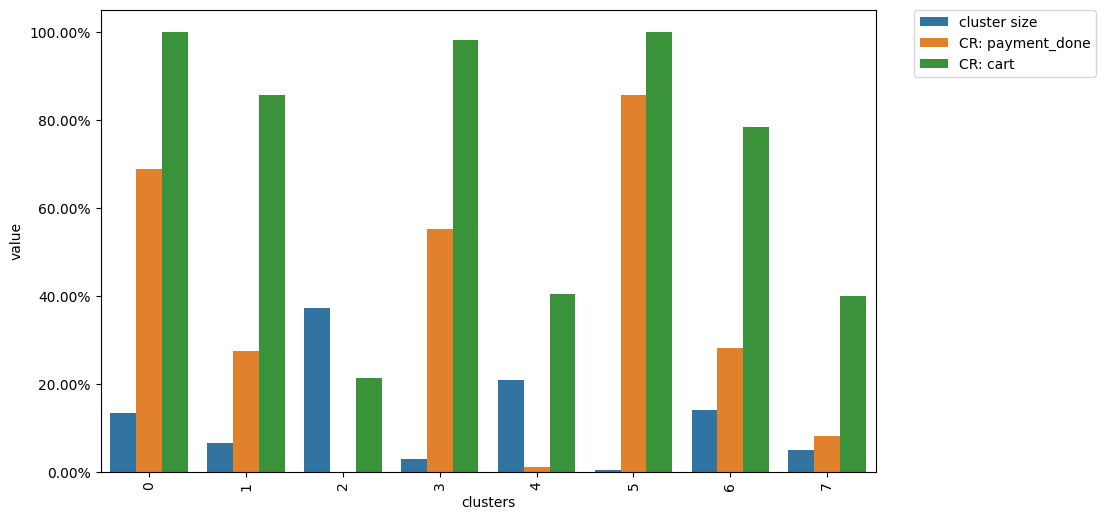

In [18]:
from retentioneering.tooling.clusters import Clusters

clusters = Clusters(eventstream=stream)
clusters.fit(method='kmeans', n_clusters=8, feature_type='count', ngram_range=(1, 1))
clusters.plot(targets=['payment_done', 'cart']);

We can see 8 clusters with the corresponding conversion rates to the specified events (% of the users in the given cluster who had at least one specified event). Suppose we would like to compare the behavior of cluster #1 compared to cluster #3. Both have relatively high conversion rate to ``payment_done`` and ``cart``. Let’s find out how they differ using differential step matrix. All we need is to get ``user_id``s collections from ``cluster_mapping`` attribute and pass it to ``groups`` parameter of step matrix:



To get more information about the ``cluster_mapping`` attribute read here: 
https://colab.research.google.com/drive/1czRNCWcena5KlyPIJR7RRuXNQltl9mKQ#scrollTo=_JpE21J-iq0Y

/Users/j.ostanina/Rete/retentioneering-tools-new-arch/retentioneering/tooling/step_matrix/step_matrix.py:323: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data = data.groupby(self.weight_col).apply(self._pad_to_center)  # type: ignore
/Users/j.ostanina/Rete/retentioneering-tools-new-arch/retentioneering/tooling/step_matrix/step_matrix.py:323: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To 

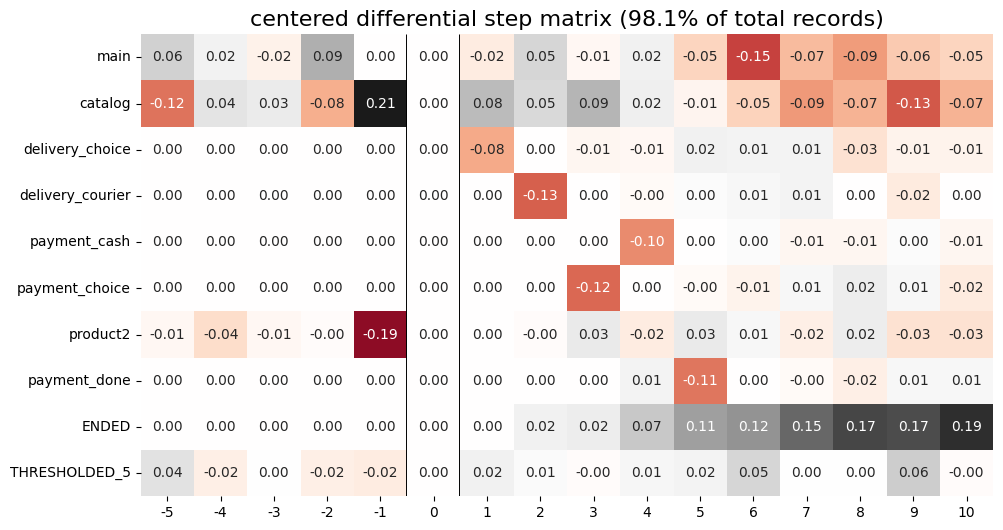

In [19]:
g1 = clusters.cluster_mapping[1]
g2 = clusters.cluster_mapping[3]

stream.step_matrix(max_steps=16,
                thresh = 0.05,
                centered={'event':'cart',
                                'left_gap':5,
                                'occurrence':1},
                groups=(g1, g2));

In this step matrix, we can see the difference between clusters #1 and #3. Users from cluster #1, after adding the product to the cart, more often returned to the catalog and continued shopping. Users from cluster #3 usually made a payment and finished their trajectory through the online shop after the ``cart`` event.

## Weight_col

So far we have been calculating step matrix values as the percentage of the users appearing in the clickstream at a certain step. However, sometimes it is reasonable to calculate similar fractions not over users, but over other entities as well. For example, over sessions.

To do this, we need to divide the event stream into sessions. The split sessions method will help us with this. 

We will set the length of the session - 100 minutes. The resulting object will be a new eventstream.

In [20]:
result = stream.split_sessions((100,'m'), session_col='session_id')

To learn more about working with data processors, you can follow the link:

https://colab.research.google.com/drive/1uXTt14stXKjWR_paEzqPl5_rZLFyclrm?usp=sharing


There is a special eventstream method in retentioneering library, called ``.timedeltahist()``. 
It can help calculate the maximum session length more accurately.
To read about this method follow the link:

https://colab.research.google.com/drive/1-VuWTmgx57YDmQtdt6CMnV3z2fcjwj32#scrollTo=dozePSrT2rxI

Now we feed the result as input to the step_matrix tool and specify the ``weight_col=['session_id']`` parameter.

/Users/j.ostanina/Rete/retentioneering-tools-new-arch/retentioneering/eventstream/eventstream.py:664: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


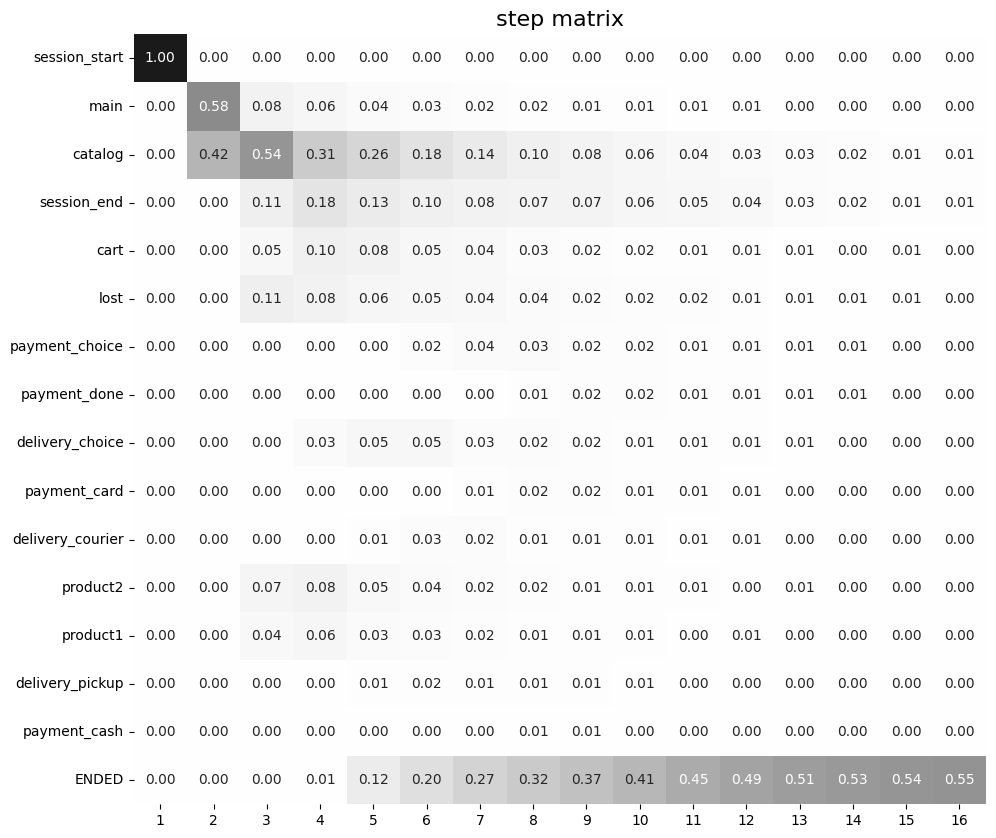

In [21]:
result.step_matrix(max_steps=16,
    weight_col=['session_id'])

Now we see in the cells the share of all sessions for which the specified event happened at the specified step. 

Let's compare the result with the user-weighted matrix

/Users/j.ostanina/Rete/retentioneering-tools-new-arch/retentioneering/eventstream/eventstream.py:664: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


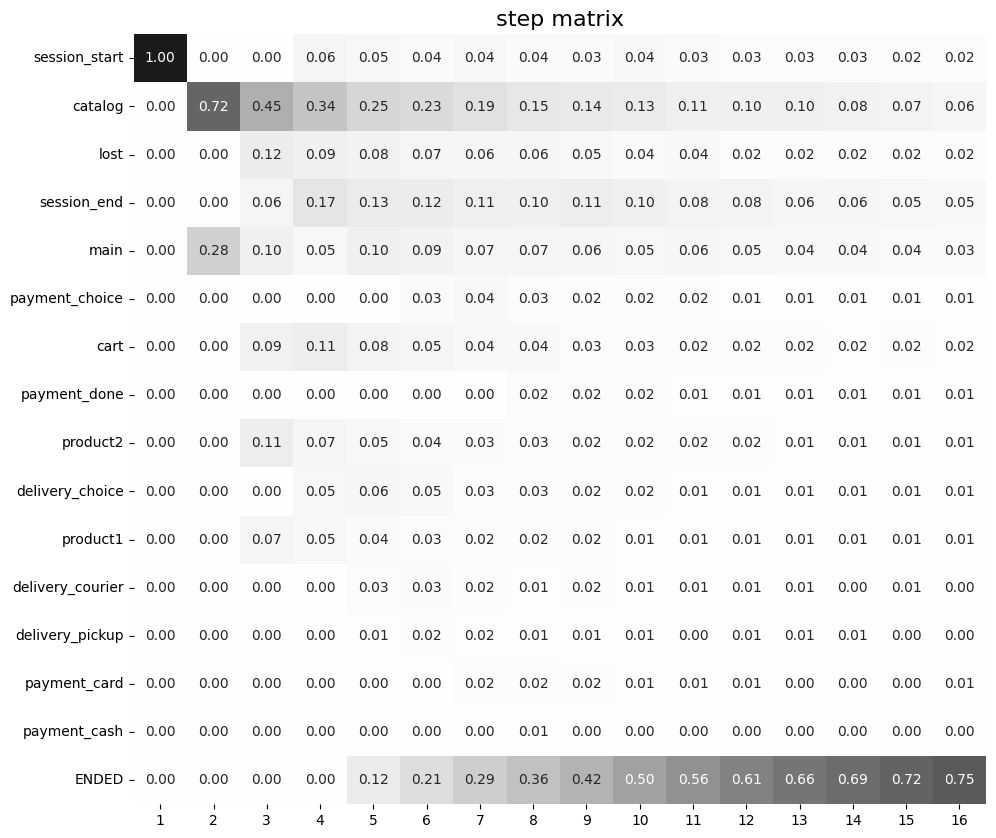

In [23]:
result.step_matrix(max_steps=16,
    weight_col=['user_id'])

Now we can see the difference between these two types of normalisation. The number of unique sessions is greater than the number of unique users, so the proportion of the ``cart`` event in the third step when normalizing by users is higher than for sessions (0,09 vs 0,05). The same happens with other, potentially targeted events in the eventstream: ``payment_choice``, ``payment_done``, ``delivery_choice`` etc. In addition, looking at the step matrix by users, we can assume that the trajectory of most users starts with the ``catalogue`` event, but if you break down the trajectories into sessions, it becomes clear that most of them start with the ``main`` event.

Using a separate instance
-------------------------

By design, `Eventstream.step_matrix()` is a shortcut method which uses an instance of `StepMatrix` class under the hood. Eventstream method creates an instance of StepMatrix object and stores it the eventstream internally.

Sometimes it's reasonable to work with a separate instance of StepMatrix class. In this case you also have to call ``StepMatrix.fit()`` and ``StepMatrix.plot()`` methods explicitly. Here's an example how you can do it.

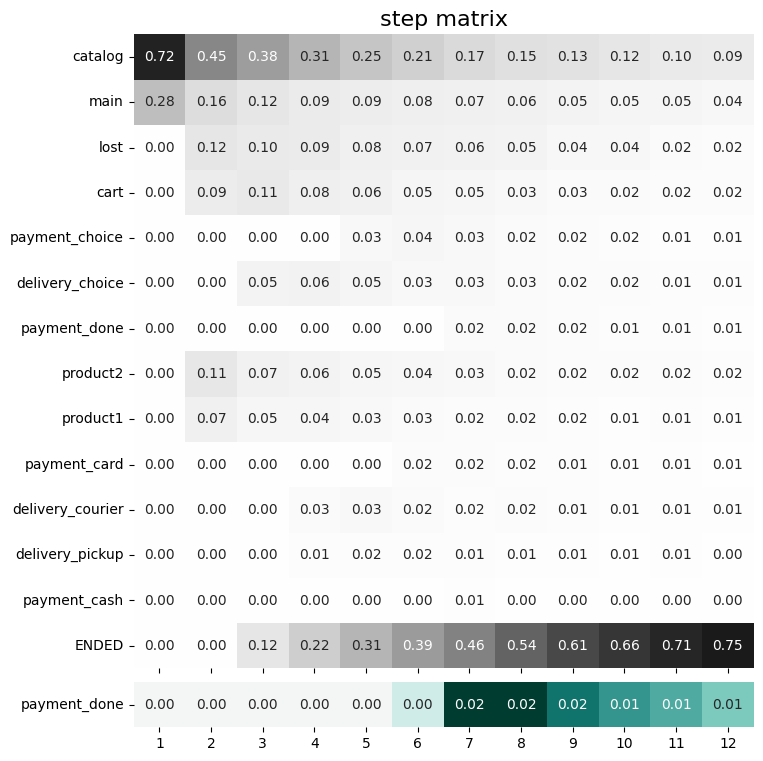

In [24]:
from retentioneering.tooling.step_matrix import StepMatrix

step_matrix = StepMatrix(stream, max_steps=12, targets=['payment_done'])
step_matrix.fit()
step_matrix.plot();

Common tooling properties
-------------------------

Regardless of how the step matrix is called, as eventstream method or as StepMatrix class instance, common properties are available.

### values

To see the matrix data, we can call the ``.values`` attribute. This attribute returns two datasets: the step matrix itself and the target events.  If we apply indexing, .values[0] returns step_matrix, .values[1] returns targets. 

In [25]:
stream\
    .step_matrix(max_steps=12,
        targets=['product1',['cart','payment_done']],
        show_plot=False)\
    .values[0]

,1,2,3,4,5,6,7,8,9,10,11,12
catalog,0.716076,0.445215,0.384164,0.310051,0.251400,0.211677,0.169022,0.147427,0.134897,0.117835,0.101840,0.094908
main,0.283924,0.162357,0.121834,0.094108,0.085311,0.079712,0.070914,0.064250,0.053586,0.050120,0.049853,0.037057
lost,0.000000,0.118102,0.101306,0.093842,0.075180,0.066649,0.060784,0.054385,0.040523,0.035724,0.023460,0.022661
cart,0.000000,0.089843,0.109571,0.080778,0.064783,0.047454,0.046388,0.031725,0.027459,0.024527,0.021061,0.022394
payment_choice,0.000000,0.000000,0.000000,0.000000,0.033591,0.043455,0.031991,0.023994,0.022661,0.017329,0.010131,0.011464
delivery_choice,0.000000,0.000000,0.054119,0.061584,0.049054,0.034391,0.031725,0.026926,0.018395,0.018395,0.014396,0.012263
payment_done,0.000000,0.000000,0.000000,0.000000,0.000000,0.003999,0.024793,0.024793,0.018395,0.014929,0.013063,0.010131
product2,0.000000,0.114370,0.065849,0.057851,0.045854,0.035724,0.030392,0.023727,0.020794,0.020261,0.017595,0.016262
product1,0.000000,0.070115,0.045055,0.042655,0.031991,0.025860,0.020794,0.017595,0.017062,0.011197,0.012263,0.010397
payment_card,0.000000,0.000000,0.000000,0.000000,0.000000,0.017595,0.020261,0.017062,0.012797,0.010664,0.010131,0.005065


In [26]:
# target events
stream\
    .step_matrix(max_steps=12,
                targets=['product1',['cart','payment_done']],
                 show_plot=False)\
    .values[1]

,1,2,3,4,5,6,7,8,9,10,11,12
product1,0.0,0.070115,0.045055,0.042655,0.031991,0.025860,0.020794,0.017595,0.017062,0.011197,0.012263,0.010397
cart,0.0,0.089843,0.109571,0.080778,0.064783,0.047454,0.046388,0.031725,0.027459,0.024527,0.021061,0.022394
payment_done,0.0,0.000000,0.000000,0.000000,0.000000,0.003999,0.024793,0.024793,0.018395,0.014929,0.013063,0.010131


### params

``StepMatrix.params`` property returns a dictionary containing all the parameters (including the defaults) related to the current state of the StepMatrix object:


In [27]:
stream\
    .step_matrix(show_plot=False)\
    .params

{'max_steps': 20,
 'weight_col': 'user_id',
 'precision': 2,
 'targets': None,
 'accumulated': None,
 'sorting': None,
 'thresh': 0,
 'centered': None,
 'groups': None}